# Show results

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp


import utils.torch_resistance_metrics as ermet
import torch
import seaborn as sns
import pandas as pd

In [150]:
N_LINKS = 5000
DATASET = 'UNC28'
PATH_FIGURES = osp.join('.', 'results', 'figures')
#MODEL = args.model
#STRATEGY = args.strategy
#DEVICE = args.device
PATH_FIGURES

'.\\results\\figures'

In [151]:
#List all folders under the folder 'results' with the name of the dataset and the number of links
folders = [f for f in os.listdir('results') if osp.isdir(osp.join('results', f)) and f.startswith(DATASET+'_') and str(N_LINKS)+'lnks' in f]
folders

['UNC28_cosine_strong_5000lnks_11_12_23__20_07_35',
 'UNC28_cosine_weak_5000lnks_11_12_23__19_09_50',
 'UNC28_ERP_strong_5000lnks_11_12_23__17_55_18',
 'UNC28_ERP_weak_5000lnks_11_12_23__17_04_01',
 'UNC28_random_weak_5000lnks_11_12_23__21_39_26',
 'UNC28_random_weak_5000lnks_11_12_23__22_16_46',
 'UNC28_random_weak_5000lnks_11_12_23__22_54_14',
 'UNC28_random_weak_5000lnks_11_12_23__23_31_37']

In [152]:
group_results_dict = {}
for fold in folders:
    # get model and strategy from folder name
    model = fold.split('_')[1]
    strategy = fold.split('_')[2]

    model_key = model+'_'+strategy

    loaded_res = pickle.load(open(osp.join('results', fold, 'results_dict.pkl'), 'rb'))
    if model_key not in group_results_dict:
        group_results_dict[model+'_'+strategy] = loaded_res
    else:
        # stack results if different runs
        for group in group_results_dict[model_key]:
            for metric in group_results_dict[model_key][group]:
                group_results_dict[model_key][group][metric] = np.vstack((group_results_dict[model_key][group][metric], loaded_res[group][metric]))

In [153]:
# get mean and std for each group and metric - Not for ERP, but random and others yes
group_mean_results_dict = {}
group_std_results_dict = {}

for model_key in group_results_dict:
    group_mean_results_dict[model_key] = {}
    group_std_results_dict[model_key] = {}
    for group in group_results_dict[model_key]:
        group_mean_results_dict[model_key][group] = {}
        group_std_results_dict[model_key][group] = {}
        for metric in group_results_dict[model_key][group]:
            runs = np.array(group_results_dict[model_key][group][metric]).ndim
            if runs == 1:
                group_mean_results_dict[model_key][group][metric] = np.array(group_results_dict[model_key][group][metric])
                group_std_results_dict[model_key][group][metric] = np.zeros(len(group_results_dict[model_key][group][metric]))
            else:
                group_mean_results_dict[model_key][group][metric] = np.mean(group_results_dict[model_key][group][metric], axis=0)
                group_std_results_dict[model_key][group][metric] = np.std(group_results_dict[model_key][group][metric], axis=0)

In [154]:
#set matplotlib style
# set font to times new roman - like paper
plt.rcParams["font.family"] = "Times New Roman"
# set tick font size
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
# set title and label font size
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
# set legend font size
plt.rcParams['legend.fontsize'] = 12
# set figure color
plt.rcParams['axes.facecolor'] = 'ghostwhite'


cmap = plt.get_cmap('Set1')

**Plots for evolution of a metric for one group with different models**
* 1 plot for each metric
* One line for each metric evolution with different models
* Only one group

In [155]:
metrics = list(group_mean_results_dict['random_weak'][0].keys())
metrics

['total_er', 'diameter', 'avg_diam', 'avg_betw', 'std_betw']

In [156]:
rename_methods = {
    'original': '$G$',
    'cosine_strong': 'W-Cos',
    'cosine_weak': 'S-Cos',
    'deepwalk_weak': 'S-DW',
    'deepwalk_strong': 'W-DW',
    'random_weak': 'Random',
    'ERP_weak': 'W-ERP',
    'ERP_strong': 'S-ERP',
}


rename_metrics = {
    'total_er': '$R_{tot}$',
    'diameter': '$\mathcal{R}_{diam}$',
    'diame': '$\mathcal{R}_{diam}$',
    'avg_diam': '$\overline{\mathcal{R}_{diam}}$',
    'avg_betw':'$\mathsf{B_R}$',
    'std_betw':'Var$(\mathsf{B_R})$'

}

rename_groups = {
    0:'Male',
    1:'Female',
}

In [157]:
def plt_evolution_group(GROUP, metric, save=False, slegend=True, lims=None):
    colors = cmap(np.linspace(0, 1, len(group_mean_results_dict)))

    if slegend:
        fig, ax = plt.subplots(figsize=(5, 3))
    else:
        fig, ax = plt.subplots(figsize=(3.9, 3))
    for i, model_key in enumerate(group_mean_results_dict):
        if i==0:
            plt.scatter(0, group_mean_results_dict[model_key][GROUP][metric][0],
                        color='black', label = rename_methods['original'],
                        zorder=10, s=50)
            xlimit = len(group_mean_results_dict[model_key][GROUP][metric])
        mean_res = group_mean_results_dict[model_key][GROUP][metric]
        std_res = group_std_results_dict[model_key][GROUP][metric]
        ax.plot(mean_res, color=colors[i], linewidth=2, alpha=0.7, label=rename_methods[model_key])
        #ax.fill_between(np.arange(len(mean_res)), mean_res-std_res, mean_res+std_res, color=colors[i], alpha=0.2)



    ax.set_title(rename_metrics[metric]+'('+rename_groups[GROUP]+')')
    ax.set_xlabel("$|\mathcal{E}'\:\\backslash\:\mathcal{E}|$")
    #ax.set_ylabel(rename_metrics[metric])

    
    # place legend outside
    if slegend:
        ax.legend(bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., fancybox=True, shadow=True,
                facecolor='white', framealpha=1,frameon=False
                )
            
    ax.set_xlim(None, xlimit-1)   
    #set ticks to show 5 points between 0 and xlimit
    ax.set_xticks(np.linspace(0, xlimit-1, 6))
    #set xticks labels to be integers
    ax.set_xticklabels(np.linspace(0, xlimit-1, 6, dtype=int)) 
    

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.6, linestyle='-.')

    if lims is not None:
        ax.set_ylim(lims[0])
        ax.set_ylim(lims[1])


    plt.tight_layout()
    if save:
        fig_name = 'evolution_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'_'+str(rename_groups[GROUP])+'.pdf'
        if not os.path.exists(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    

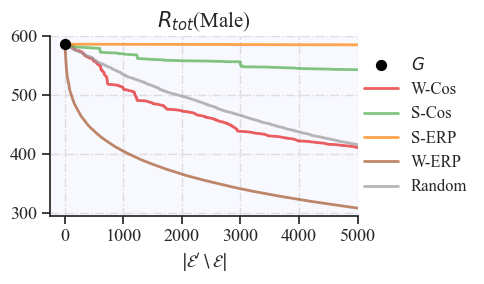

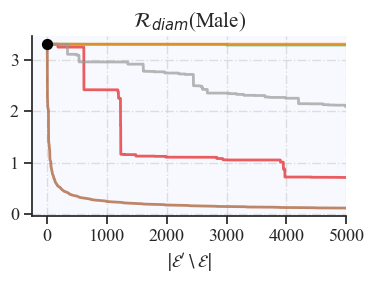

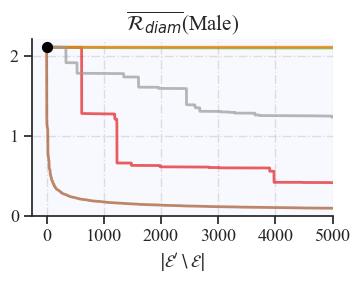

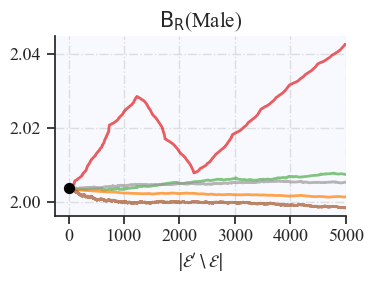

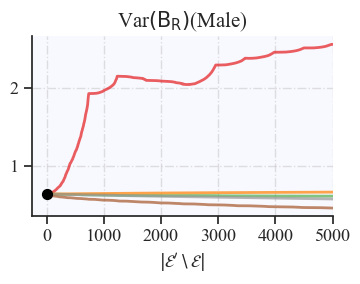

In [159]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    plt_evolution_group(0, metric,save=False, slegend=showleg)

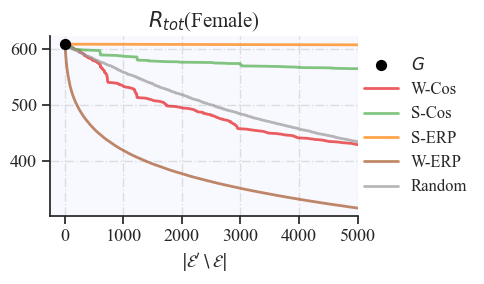

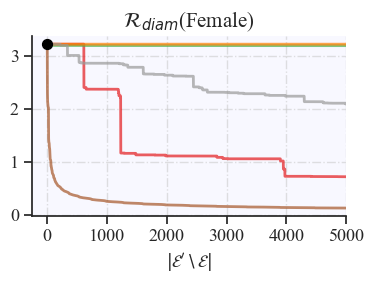

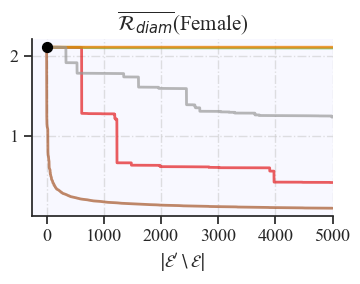

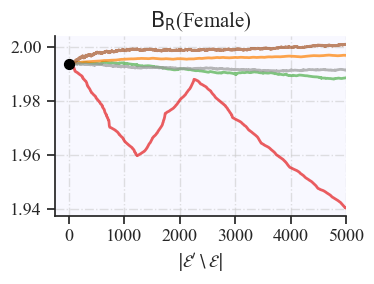

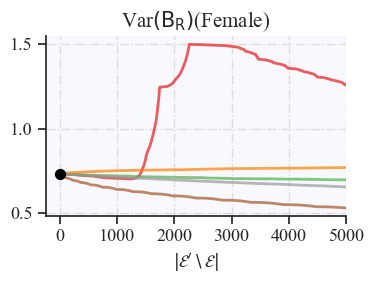

In [161]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    plt_evolution_group(1, metric,save=False, slegend=showleg)

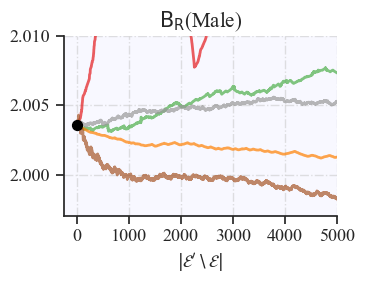

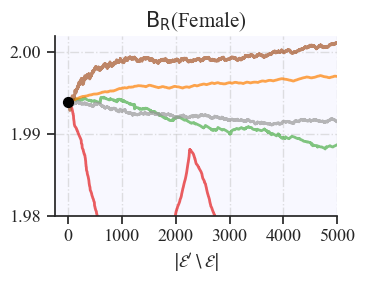

In [174]:
plt_evolution_group(0, 'avg_betw',save=False, slegend=False, lims=[None, (1.997, 2.01)])
plt_evolution_group(1, 'avg_betw',save=False, slegend=False, lims=[None, (1.98, 2.002)])

**Plots for evolution of a metric for BOTH groups with different models**
* 1 plot for each metric
* One line for each metric evolution with different models and different groups
* Same model - same color && same group - same linestyle

In [179]:
def plot_evolution_all_g(metric, save=False, slegend = True, lims=None):  
    colors = cmap(np.linspace(0, 1, len(group_mean_results_dict)))
    linestyles = ['-', '--', '-.', ':']


    if slegend:
        fig, ax = plt.subplots(figsize=(5, 3))
    else:
        fig, ax = plt.subplots(figsize=(3.9, 3))
    for i, model_key in enumerate(group_mean_results_dict):
        if i==0:
            plt.scatter(0, group_mean_results_dict[model_key][0][metric][0],
                        color='black', 
                        zorder=10, s=50)
            plt.scatter(0, group_mean_results_dict[model_key][1][metric][0],
                        color='black',
                        zorder=10, s=50)
        for j, group in enumerate(group_mean_results_dict[model_key]):
            mean_res = group_mean_results_dict[model_key][group][metric]
            std_res = group_std_results_dict[model_key][group][metric]
            ax.fill_between(np.arange(len(mean_res)), mean_res-std_res, mean_res+std_res, color=colors[i], alpha=0.2)
            ax.plot(mean_res, color=colors[i], linestyle=linestyles[j], alpha=0.7, linewidth=2)
            try:
                if metric == 'avg_betw':
                    #ax.axhline(2- (1/GW.num_nodes))
                    pass
            except:
                pass


    ax.set_title(rename_metrics[metric])
    ax.set_xlabel("$|\mathcal{E}'\:\\backslash\:\mathcal{E}|$")
    #ax.set_ylabel(rename_metrics[metric])

    if slegend:
        #Dummy lines to create legend
        handles_method = []
        labels_method = []
        handles_group = []
        labels_group = []
        for i, model_key in enumerate(group_mean_results_dict):
            handles_method.append(plt.Line2D([], [], color=colors[i]))
            labels_method.append(rename_methods[model_key])
        for j, group in enumerate(group_mean_results_dict[model_key]):
            handles_group.append(plt.Line2D([], [], linestyle=linestyles[j], color='black'))
            labels_group.append(f'${rename_groups[group]}$')
        # place legend outside
        ax.legend(handles_method+handles_group, labels_method+labels_group, bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., fancybox=True, shadow=True, ncols=1,
                columnspacing=0.5, handletextpad=0.5, borderpad=0.5, labelspacing=0.5,
                facecolor='white', framealpha=1,frameon=False)
    

    #semitransparent grid and -. style
    ax.grid(alpha=0.6, linestyle='-.')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(None, N_LINKS)   
    #set ticks to show 5 points between 0 and xlimit
    ax.set_xticks(np.linspace(0, N_LINKS, 6))
    #set xticks labels to be integers
    ax.set_xticklabels(np.linspace(0, N_LINKS, 6, dtype=int))

    if lims is not None:
        ax.set_ylim(lims[0])
        ax.set_ylim(lims[1])

    
    plt.tight_layout()
    
    if save:
        fig_name = fig_name = 'evolution_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'_BOTH.pdf'
        if not osp.exists(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

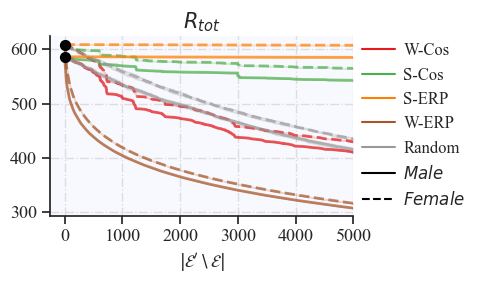

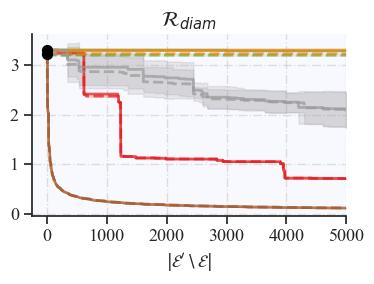

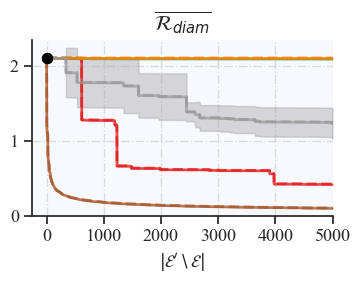

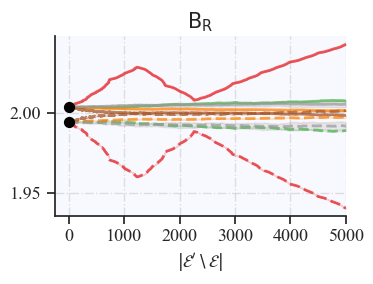

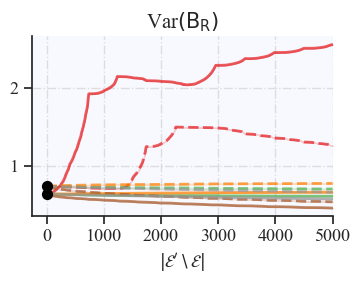

In [180]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    plot_evolution_all_g(metric, save=False, slegend=showleg)
    

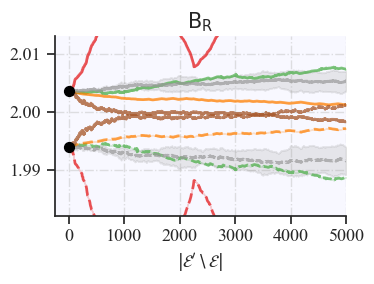

In [222]:
plot_evolution_all_g('avg_betw', save=False, slegend=False, lims=[None, (1.982, 2.013)])

**Plots for evolution of a the fairness metric for each model**
* 1 plot for each fairness metric (difference of the metric for male and female)
* One line for each fair metric evolution with different models
* Fair metric comprenheds both groups

In [183]:
def plot_evolution_fair(metric, save=False, slegend = True, lims=None):   
    
    colors = cmap(np.linspace(0, 1, len(group_mean_results_dict)))
    if slegend:
        fig, ax = plt.subplots(figsize=(5, 3))
    else:
        fig, ax = plt.subplots(figsize=(3.9, 3))
    
    for i, model_key in enumerate(group_mean_results_dict):
        mean_res = np.array(group_mean_results_dict[model_key][1][metric]) - np.array(group_mean_results_dict[model_key][0][metric])
        ax.plot(np.abs(mean_res), label=rename_methods[model_key], color=colors[i], alpha=0.7, linewidth=2)
        #std_res = group_std_results_dict[model_key][1][metric]+group_std_results_dict[model_key][0][metric]
        #ax.fill_between(np.arange(len(mean_res)), mean_res-std_res, mean_res+std_res, color=colors[i], alpha=0.2)
    ax.set_title(fr'$\Delta$ {rename_metrics[metric]}')
    ax.set_xlabel("$|\mathcal{E}'\:\\backslash\:\mathcal{E}|$")
    #ax.set_ylabel(fr'$\Delta$ {rename_metrics[metric]}')
    
    if slegend:
        ax.legend(bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., fancybox=True, shadow=True, ncols=1,
                columnspacing=0.5, handletextpad=0.5, borderpad=0.5, labelspacing=0.5,
                facecolor='white', framealpha=1,frameon=False)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.6, linestyle='-.')
    
    ax.set_xlim(None, N_LINKS)   
    #set ticks to show 5 points between 0 and xlimit
    ax.set_xticks(np.linspace(0, N_LINKS, 6))
    #set xticks labels to be integers
    ax.set_xticklabels(np.linspace(0, N_LINKS, 6, dtype=int)) 

    if lims is not None:
        ax.set_ylim(lims[0])
        ax.set_ylim(lims[1])

    
    plt.tight_layout()
    
    if save:
        fig_name = fig_name = 'evolution_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'_FAIR.pdf'
        if not osp.exists(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'evolution', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

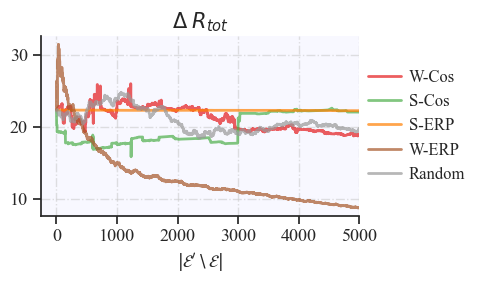

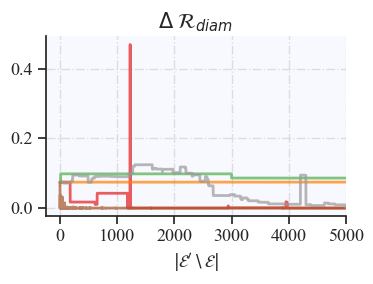

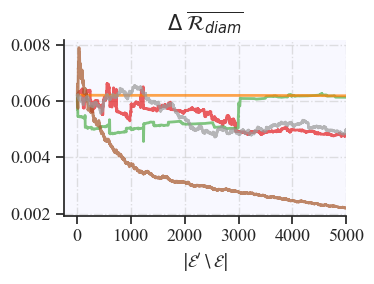

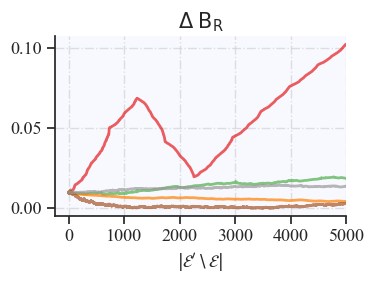

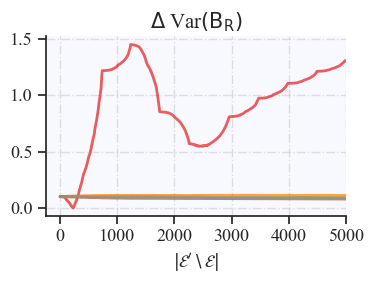

In [185]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    plot_evolution_fair(metric, save=False, slegend=showleg)

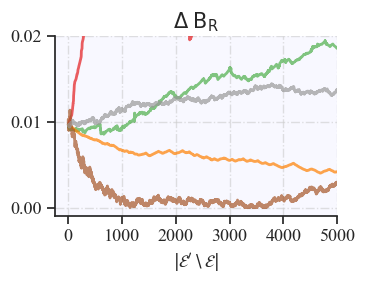

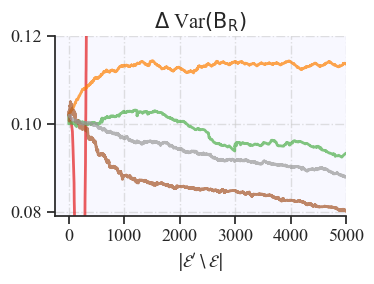

In [195]:
plot_evolution_fair('avg_betw', save=False, slegend=showleg, lims=[None, (-0.001, 0.02)])
plot_evolution_fair('std_betw', save=False, slegend=showleg, lims=[None, (0.079, 0.12)])

## Pareto fronts

In [191]:
dict_final_results = {}
for model_key in group_mean_results_dict:
    dict_final_results[model_key] = {}
    for group in group_mean_results_dict[model_key]:
        dict_final_results[model_key]
        for metric in group_mean_results_dict[model_key][group]:
            dict_final_results[model_key][(metric,group)] = group_mean_results_dict[model_key][group][metric][-1]
    

df_pareto = pd.DataFrame.from_dict(dict_final_results).T

In [235]:
def pareto_metric(metric, df, save=False, slegend=True):
    if slegend:
        fig, ax = plt.subplots(figsize=(4.52, 3))
    else:
        fig, ax = plt.subplots(figsize=(3.4, 3))
    colors = cmap(np.linspace(0, 1, len(df.index)))
    for i, model_key in enumerate(df.index):
        ax.scatter(np.abs(df[metric].loc[model_key][1]-df[metric].loc[model_key][0]),
                   df[metric].loc[model_key][0]+df[metric].loc[model_key][1],
                   label=rename_methods[model_key], color=colors[i], s=80, alpha=0.7)
    # plot legend outside
    
    #ax.set_title(rename_metrics[metric])
    ax.set_xlabel(fr'$\Delta$ {rename_metrics[metric]}')
    ax.set_ylabel(fr'$\sum${rename_metrics[metric]}$(s)$   $\forall s \in S$')
    ax.grid(alpha=0.6, linestyle='-.')

    

    if slegend:
        ax.legend(bbox_to_anchor=(1.0, .5), loc='center left',
                borderaxespad=0., fancybox=True, shadow=True, ncols=1,
                columnspacing=0.5, handletextpad=0.5, borderpad=0.5, labelspacing=0.5,
                facecolor='white', framealpha=1,frameon=False)


    if metric == 'avg_betw':
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.tight_layout()
    if save:
        fig_name = fig_name = 'pareto_'+DATASET+'_'+str(N_LINKS)+'_'+metric+'.pdf'
        if not osp.exists(osp.join(PATH_FIGURES, 'pareto', DATASET, str(N_LINKS))):
            os.makedirs(osp.join(PATH_FIGURES, 'pareto', DATASET, str(N_LINKS)))
        plt.savefig(osp.join(PATH_FIGURES, 'pareto', DATASET, str(N_LINKS), fig_name),
                    dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

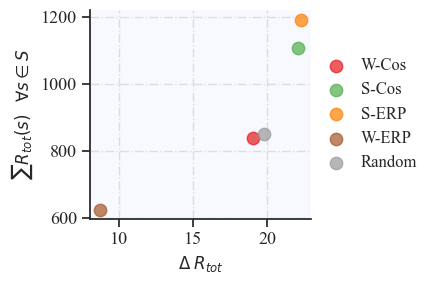

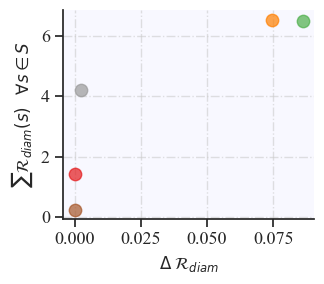

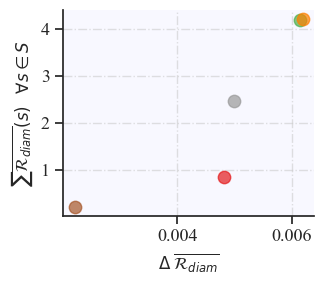

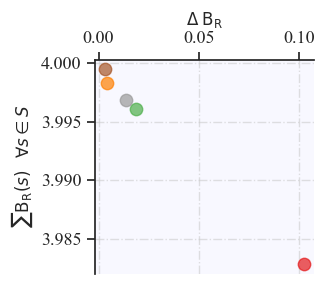

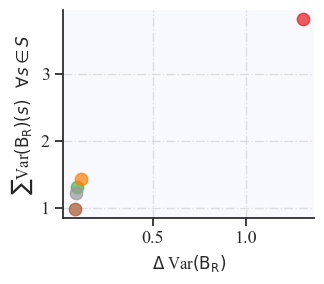

In [236]:
for metric in metrics:
    showleg = True if metric=='total_er' else False
    pareto_metric(metric, df_pareto, save=True, slegend=showleg)

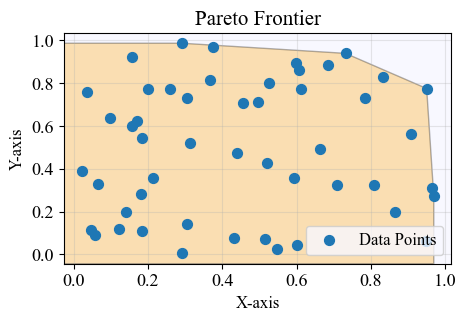

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Sample data
np.random.seed(42)
x = np.random.rand(50)
y = np.random.rand(50)

# Function to check if a point dominates another
def dominates(x1, y1, x2, y2):
    return (x1 >= x2 and y1 >= y2) and (x1 > x2 or y1 > y2)

# Identify Pareto points    
pareto_set = []
for i in range(len(x)):
    is_pareto = all(not dominates(x[j], y[j], x[i], y[i]) for j in range(len(x)))
    if is_pareto:
        pareto_set.append((x[i], y[i]))

plt.figure(figsize=(5, 3))
plt.scatter(x, y, label='Data Points', zorder=3, s=50)


# add limits of the plot to the paresoset
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
pareto_set.append((xlim[0],ylim[0]))
plt.ylim(ylim)
plt.xlim(xlim)
# add pareto sex max first dimension
pareto_set.append((xlim[0],max([t[1] for t in pareto_set])))
pareto_set.append((max([t[0] for t in pareto_set]), ylim[0]))
#pareto_set.append((0,1))
# Create a scatter plot


# Identify convex hull of Pareto set
points = np.array(pareto_set)
hull = ConvexHull(points)
plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], edgecolor='black', facecolor='orange', alpha=0.3)

# Set plot properties
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Pareto Frontier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


##  Violinplots

In [92]:
ER_dict = {}
for fold in folders:
    # get model and strategy from folder name
    model = fold.split('_')[1]
    strategy = fold.split('_')[2]

    model_key = model+'_'+strategy

    loaded_ER = np.load(open(osp.join('results', fold, 'R.npy'), 'rb'))
    ER_dict[model_key] = loaded_ER

In [93]:
import utils.data_loader as loader
GW = loader.load_data(dataset = DATASET,
                      device = 'cpu')

exact


In [94]:
ER_dict['original'] = GW.get_effective_resistance().numpy()

In [95]:
distances = []
keys = []
for key in ER_dict:
    #get triangular superior matrix
    dist = ER_dict[key][np.triu_indices(ER_dict[key].shape[0], k=1)]
    distances.append(dist)
    keys.append(key)

**All RW**

In [96]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette = "Set2", rc=custom_params)

In [97]:
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ER_dict[key][np.triu_indices(ER_dict[key].shape[0], k=1)]
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(var_name='method', value_name='Ruv')

In [98]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='method', y = 'Ruv', orient='v',
               split=False, scale='width', linewidth=1, cut=0)
#change labels
plt.xticks(np.arange(len(keys)), [rename_methods[key] for key in keys])
plt.xlabel('')
plt.ylabel('$R_{uv}$')
#plt.ylim(0,1)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

<Figure size 800x400 with 0 Axes>

**Res G**

In [ ]:
# create empty pandas with columns
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ermet.node_total_er(torch.Tensor(ER_dict[key]))
df['sens'] = GW.sens.numpy()
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(id_vars=['sens'], var_name='method', value_name='total_er')

In [ ]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='method', y = 'total_er', hue='sens', orient='v', split=True,
               scale='width',cut=0)
plt.xticks(np.arange(len(keys)), [rename_methods[key] for key in keys])
plt.xlabel('')
plt.ylabel(rename_metrics['total_er'])
plt.tight_layout()
#plt.ylim(None, 500)
plt.show()

In [ ]:
# create empty pandas with columns
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ermet.node_diam(torch.Tensor(ER_dict[key]))
df['sens'] = GW.sens.numpy()
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(id_vars=['sens'], var_name='method', value_name='diameter')


In [ ]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='method', y = 'diameter', hue='sens', orient='v',
               split=True, cut=0, scale='width')
plt.xlabel('')
plt.ylabel(rename_metrics['diameter'])
plt.xticks(np.arange(len(keys)), [rename_methods[key] for key in keys])
plt.tight_layout()
plt.show()

In [ ]:
# create empty pandas with columns
df = pd.DataFrame(columns=ER_dict.keys())
for key in ER_dict:
    df[key] = ermet.node_betwenness(torch.Tensor(ER_dict[key]), ~GW.edge_mask)
df['sens'] = GW.sens.numpy()
#pivot df to have one clumn named method, so the finals columns are total_er, method and sens
df = df.melt(id_vars=['sens'], var_name='method', value_name='betw')

In [ ]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='method', y = 'betw', hue='sens', orient='v', split=True,cut=0)
plt.xlabel('')
plt.ylabel(rename_metrics['avg_betw'])
plt.xticks(np.arange(len(keys)), [rename_methods[key] for key in keys])
plt.tight_layout()
plt.show()

## Tables
* Improvement on all metrics for one group
  * Models x metrics = init - final
* Improvement of fairness metrics
  * Models - metrics = (init0-init1) - (final0-final1)

Improvement for one group

In [196]:
GROUP = 0

In [197]:
#make a pandas where columns are the metrics, rows are the methods and values are the initial metric minus the final metric
metrics = list(group_mean_results_dict[next(iter(group_mean_results_dict))][0].keys())
df = pd.DataFrame(columns=metrics)
for model_key in group_mean_results_dict:
    df.loc[model_key] = [group_mean_results_dict[model_key][GROUP][metric][-1]-group_mean_results_dict[model_key][GROUP][metric][0] for metric in metrics]

for metric in metrics:
    df.loc['original', metric] = group_mean_results_dict['ERP_weak'][GROUP][metric][0]

In [198]:
models = ['original',
        'deepwalk_weak', 'cosine_weak', 'ERP_strong', 'random_weak', 
        'deepwalk_strong', 'cosine_strong', 'ERP_weak']

models = ['original']+[mod for mod in models if mod in group_mean_results_dict]
models

['original',
 'cosine_weak',
 'ERP_strong',
 'random_weak',
 'cosine_strong',
 'ERP_weak']

In [199]:
df = df.loc[models]

In [200]:
df.rename(index=rename_methods, inplace=True)
df.rename(columns=rename_metrics, inplace=True)

In [201]:
print(df.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrr}
\toprule
 & $R_{tot}$ & $\mathcal{R}_{diam}$ & $\overline{\mathcal{R}_{diam}}$ & $\mathsf{B_R}$ & Var$(\mathsf{B_R})$ \\
\midrule
$G$ & 586.2866 & 3.3024 & 2.1048 & 2.0036 & 0.6324 \\
S-Cos & -43.3095 & -0.0163 & -0.0096 & 0.0038 & -0.0277 \\
S-ERP & -1.1158 & -0.0001 & -0.0002 & -0.0023 & 0.0243 \\
Random & -171.0860 & -1.2096 & -0.8718 & 0.0017 & -0.0646 \\
W-Cos & -175.6549 & -2.5866 & -1.6874 & 0.0390 & 1.9324 \\
W-ERP & -278.2071 & -3.1800 & -2.0053 & -0.0053 & -0.1817 \\
\bottomrule
\end{tabular}



Improvement for the other group

In [202]:
GROUP = 1

In [203]:
#make a pandas where columns are the metrics, rows are the methods and values are the initial metric minus the final metric
metrics = list(group_mean_results_dict[next(iter(group_mean_results_dict))][0].keys())
df = pd.DataFrame(columns=metrics)
for model_key in group_mean_results_dict:
    df.loc[model_key] = [group_mean_results_dict[model_key][GROUP][metric][-1]-group_mean_results_dict[model_key][GROUP][metric][0] for metric in metrics]

In [204]:
for metric in metrics:
    df.loc['original', metric] = group_mean_results_dict['ERP_weak'][GROUP][metric][0]

In [205]:
df = df.loc[models]

In [206]:
df.rename(index=rename_methods, inplace=True)
df.rename(columns=rename_metrics, inplace=True)

In [207]:
df

,$R_{tot}$,$\mathcal{R}_{diam}$,$\overline{\mathcal{R}_{diam}}$,$\mathsf{B_R}$,Var$(\mathsf{B_R})$
$G$,608.656250,3.228127,2.110983,1.993894,0.734414
S-Cos,-43.592102,-0.028074,-0.009676,-0.005161,-0.036304
S-ERP,-1.202515,-0.000210,-0.000185,0.003169,0.035916
Random,-173.643028,-1.132722,-0.873062,-0.002351,-0.078698
W-Cos,-178.973206,-2.512322,-1.688816,-0.053606,0.524403
W-ERP,-291.817566,-3.105716,-2.009329,0.007329,-0.203619


In [208]:
print(df.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrr}
\toprule
 & $R_{tot}$ & $\mathcal{R}_{diam}$ & $\overline{\mathcal{R}_{diam}}$ & $\mathsf{B_R}$ & Var$(\mathsf{B_R})$ \\
\midrule
$G$ & 608.6562 & 3.2281 & 2.1110 & 1.9939 & 0.7344 \\
S-Cos & -43.5921 & -0.0281 & -0.0097 & -0.0052 & -0.0363 \\
S-ERP & -1.2025 & -0.0002 & -0.0002 & 0.0032 & 0.0359 \\
Random & -173.6430 & -1.1327 & -0.8731 & -0.0024 & -0.0787 \\
W-Cos & -178.9732 & -2.5123 & -1.6888 & -0.0536 & 0.5244 \\
W-ERP & -291.8176 & -3.1057 & -2.0093 & 0.0073 & -0.2036 \\
\bottomrule
\end{tabular}



**Difference for both groups**

In [215]:
group_mean_results_dict.keys()

dict_keys(['cosine_strong', 'cosine_weak', 'ERP_strong', 'ERP_weak', 'random_weak'])

In [216]:
#make a pandas where columns are the metrics, rows are the methods and values are the difference between the final metric between the two groups
metrics = list(group_mean_results_dict[next(iter(group_mean_results_dict))][0].keys())
df = pd.DataFrame(columns=metrics)
for model_key in group_mean_results_dict:
    df.loc[model_key] = [group_mean_results_dict[model_key][1][metric][-1]-group_mean_results_dict[model_key][0][metric][-1] for metric in metrics]

In [217]:
for metric in metrics:
    df.loc['original', metric] = group_mean_results_dict['ERP_weak'][1][metric][0]-group_mean_results_dict['ERP_weak'][0][metric][0]

In [218]:
df = df.loc[models]
df.rename(index=rename_methods, inplace=True)
df.rename(columns={k: fr'$\delta${v}' for k,v in rename_metrics.items()}, inplace=True)

In [219]:
df.abs()

,$\delta$$R_{tot}$,$\delta$$\mathcal{R}_{diam}$,$\delta$$\overline{\mathcal{R}_{diam}}$,$\delta$$\mathsf{B_R}$,$\delta$Var$(\mathsf{B_R})$
$G$,22.369690,0.074295,0.006211,0.009680,0.102018
S-Cos,22.087097,0.086097,0.006135,0.018595,0.093383
S-ERP,22.282959,0.074451,0.006189,0.004206,0.113672
Random,19.812614,0.002577,0.004994,0.013742,0.087938
W-Cos,19.051392,0.000000,0.004819,0.102276,1.305984
W-ERP,8.759186,0.000000,0.002200,0.002980,0.080130


In [220]:
print(df.abs().to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrr}
\toprule
 & $\delta$$R_{tot}$ & $\delta$$\mathcal{R}_{diam}$ & $\delta$$\overline{\mathcal{R}_{diam}}$ & $\delta$$\mathsf{B_R}$ & $\delta$Var$(\mathsf{B_R})$ \\
\midrule
$G$ & 22.3697 & 0.0743 & 0.0062 & 0.0097 & 0.1020 \\
S-Cos & 22.0871 & 0.0861 & 0.0061 & 0.0186 & 0.0934 \\
S-ERP & 22.2830 & 0.0745 & 0.0062 & 0.0042 & 0.1137 \\
Random & 19.8126 & 0.0026 & 0.0050 & 0.0137 & 0.0879 \\
W-Cos & 19.0514 & 0.0000 & 0.0048 & 0.1023 & 1.3060 \\
W-ERP & 8.7592 & 0.0000 & 0.0022 & 0.0030 & 0.0801 \\
\bottomrule
\end{tabular}

